In [1]:
import pandas as pd
import numpy as np
import torch
import dice_ml


from torch import nn
from classification_code.Classification import  (
    NNClassifier, balance_dataset, cap_outliers_IQR, 
    analyze_class_imbalance, final_train_classifier, compute_class_weights
)
from classification_code.utils import OurDataset
from classification_code.xai import analyze_model
from functools import partial


In [2]:

def bin_points(df):
    bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
    labels = ['None', 'Very_Low', 'Low', 'Medium', 'High', 'Very_High', 'Exceptional']
    merged_points = np.ceil((df['uci_points'] * 0.5 + df['points'] * 0.5))
    df['points_category'] = pd.cut(merged_points, bins=bins, labels=labels, include_lowest=True)
    df = df.drop(columns=['uci_points', 'points'])

    return df
train_dataset_path = "dataset_classification/TrainDataset.csv"
test_dataset_path = "dataset_classification/TestDataset.csv"
numerical_features = ['length', 'climb_total', 'profile', 'startlist_quality', 'cyclist_age', 'delta']


train_dataset = OurDataset(train_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])
train_labels = train_dataset.labels
test_dataset = OurDataset(test_dataset_path, apply_transformers=True, call_on_df_funcs=[bin_points])

balanced_dataset, y_balanced = balance_dataset(train_dataset.data, train_labels, method="smote")

train_dataset.update_data(balanced_dataset, y_balanced)

train_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features) # Cap outliers using IQR method with a multiplier of 2.0 (conservative)
test_dataset.apply_on_df(partial(cap_outliers_IQR, multiplier=2.0), features_to_apply=numerical_features)
model = NNClassifier.load_from_checkpoint("/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/cls_logs/fold_1/202501042342/checkpoints/epoch=8-step=53478.ckpt")


In [3]:
# analyze_class_imbalance(train_dataset.labels)

In [4]:
config = {
    "input_dim": train_dataset.shape[1],
    "hidden_dims": [64],
    "batch_size": 128,
    "act_fn": nn.GELU(),
    "optimizer": torch.optim.AdamW,
    "dropout": 0.21,
    "monitor": "train_loss",
    "max_epochs": 3,
    "model_save_path": "models/classifier",
}

trainer_config = {
    "accelerator": "gpu",
    "devices": 1,
    "strategy": "auto",
    "precision": 32,
    "enable_progress_bar": True,
}
optimizer_params = {
    "lr": 0.0039,
    "weight_decay": 0.0002,
}


config["optimizer_params"] = optimizer_params
config["trainer_config"] = trainer_config

# classifier = final_train_classifier(train_dataset.to_tensor(), train_dataset.label_tensor, **config)

In [5]:
# classifier.eval()
# with torch.no_grad():
#     predictions = (torch.sigmoid(classifier(test_dataset.to_tensor())) > 0.5).int()
#     # predictions = torch.argmax(predictions, dim=1)


INFO:classification_code.xai:Generating SHAP explanations...


  0%|          | 0/36 [00:00<?, ?it/s]

INFO:classification_code.xai:Setting up LIME explainer...
INFO:classification_code.xai:Data interface: <dice_ml.data_interfaces.public_data_interface.PublicData object at 0x763dfeb60c20>
INFO:classification_code.xai:Initializing DiCE explainer...
INFO:classification_code.xai:HEEEEERERER ----- 1
  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: expected 2D or 3D input (got 1D input)

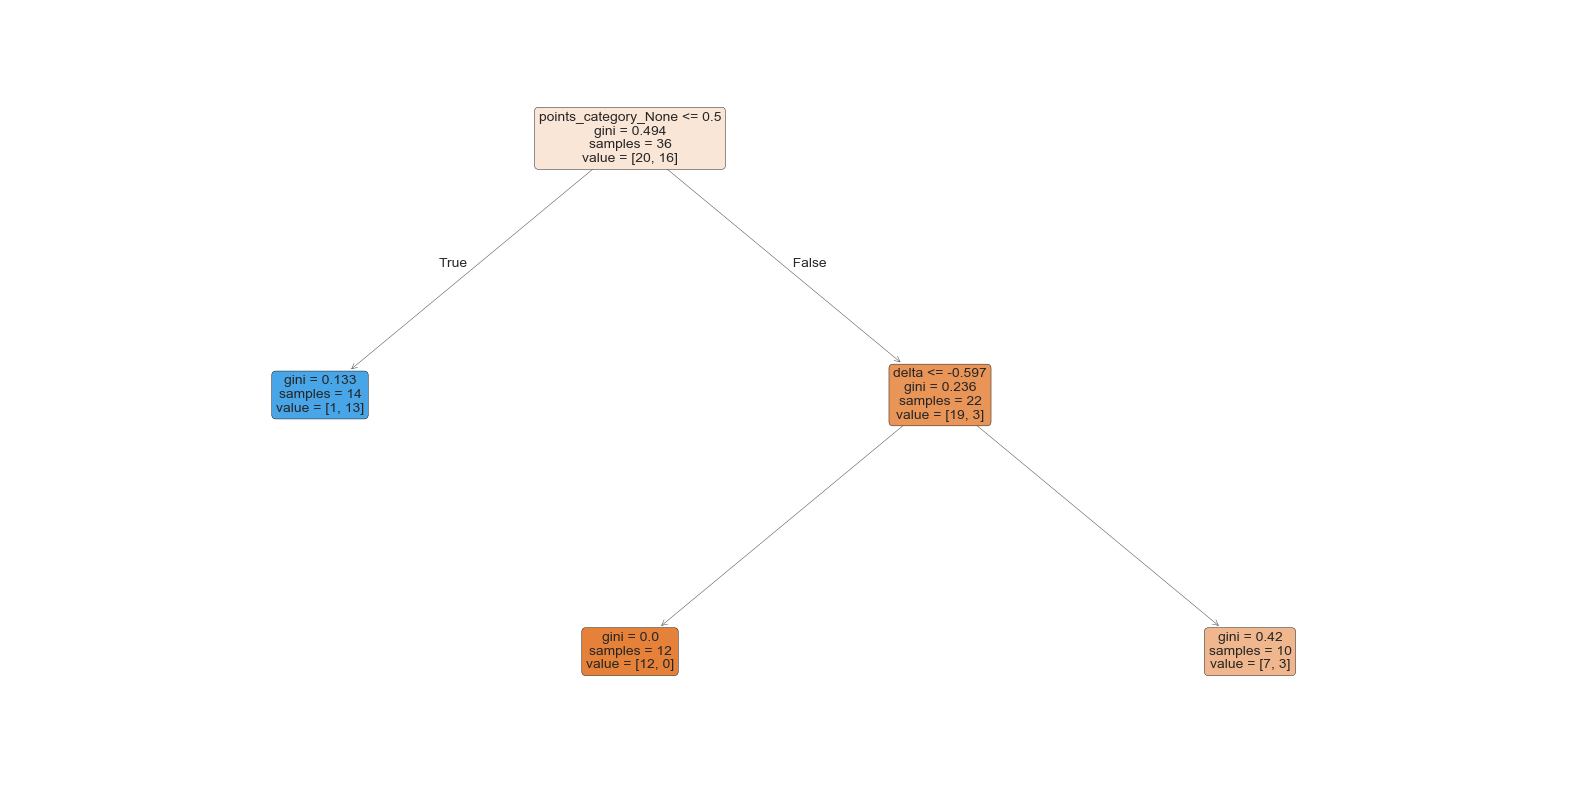

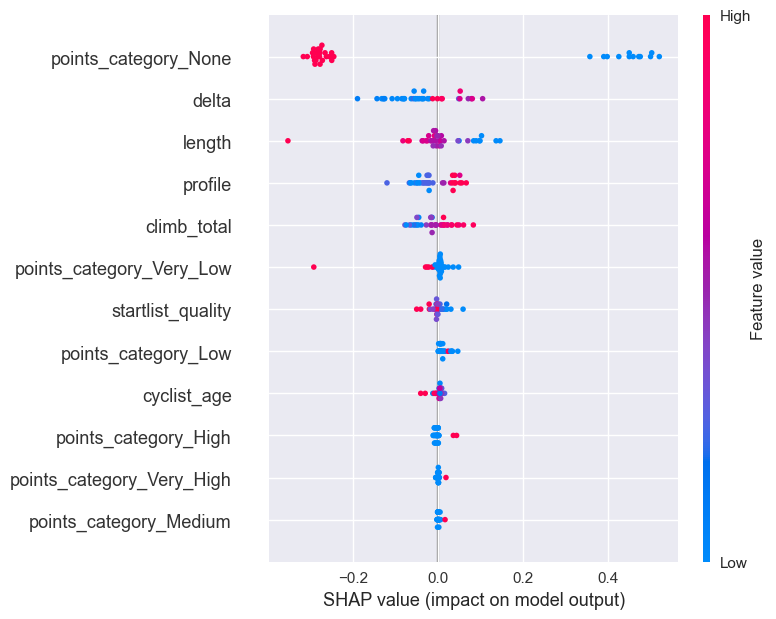

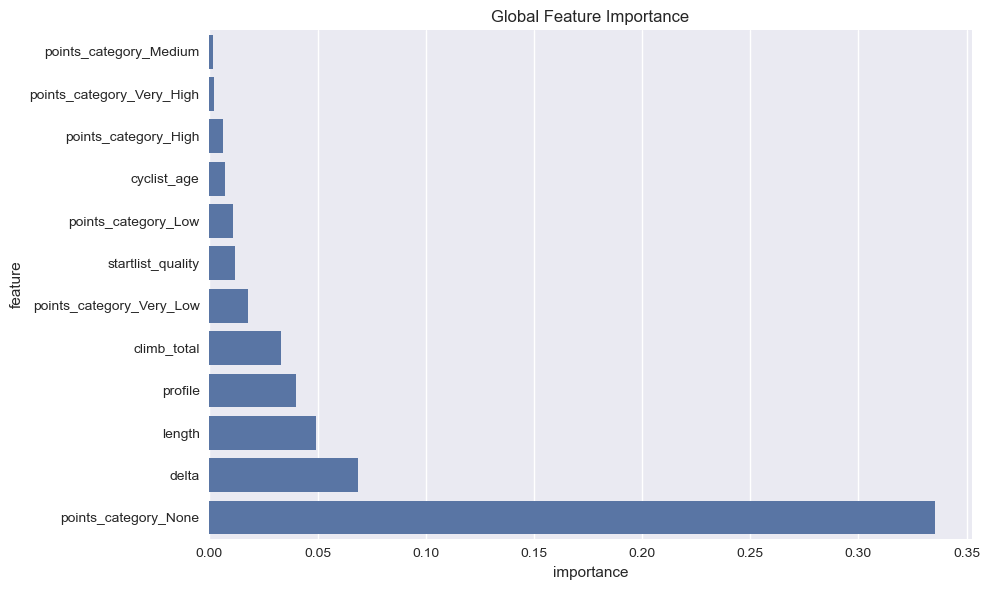

<Figure size 1000x600 with 0 Axes>

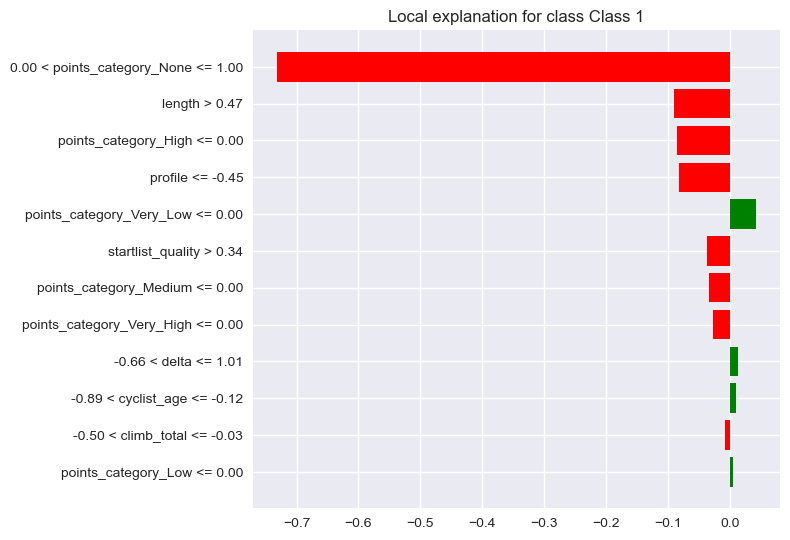

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
state_dict = torch.load("/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-O/models/classifier/NNClassifier_20250105013430", weights_only=True)

config_copy = config.copy()
del config_copy["model_save_path"]
del config_copy["monitor"]
del config_copy["max_epochs"]
del config_copy["trainer_config"]
del config_copy["batch_size"]
del config_copy["optimizer_params"]
model = NNClassifier(**config_copy)
model.load_state_dict(state_dict)
num_samples_train = 36 // 2
num_samples_test = 36 // 2

train_class_1 = train_dataset.data[train_dataset.labels == 1]
train_class_2 = train_dataset.data[train_dataset.labels == 0]
train_sample_1 = train_class_1.sample(n=num_samples_train, random_state=42)
train_sample_2 = train_class_2.sample(n=num_samples_train, random_state=42)
X_train = pd.concat([train_sample_1, train_sample_2]).values.astype(np.float32)

test_class_1 = test_dataset.data[test_dataset.labels == 1]
test_class_2 = test_dataset.data[test_dataset.labels == 0]
test_sample_1 = test_class_1.sample(n=num_samples_test, random_state=42)
test_sample_2 = test_class_2.sample(n=num_samples_test, random_state=42)
X_test = pd.concat([test_sample_1, test_sample_2]).values.astype(np.float32)

feature_names=train_dataset.data.columns

model.eval()
with torch.no_grad():
    predictions = (torch.sigmoid(model(torch.from_numpy(X_train)) > 0.5)).int()



continuous_features = [
    'length', 
    'climb_total',
    'profile',
    'startlist_quality',
    'cyclist_age',
    'delta'
]


dice_df = pd.DataFrame(X_train, columns=feature_names)
dice_df['prediction'] = pd.Series(predictions.squeeze().numpy())
encoded_categories = [col for col in dice_df.columns if col.startswith('points_category_')]

d = dice_ml.Data(
    dataframe=dice_df,
    continuous_features=continuous_features,
    categorical_features=['points_category'],
    outcome_name='prediction',
    features_to_vary=continuous_features + ['points_category'],
    permitted_range={
        col: [0, 1] for col in encoded_categories  # Binary range for one-hot encoded features
    }
)

analyze_model(
    model=model, X_train=X_train, X_test=X_test, 
    feature_names=train_dataset.data.columns, save_dir="models/xai_results",
    data_interface=d
)

